In [1]:
%load_ext autoreload
%autoreload 2

## To simplify headache, I define all things needed to be changed HERE

WORK_DIR = "/work/06782/ysu707/ls6/DAForLinGen"
CACHE_DIR = "/work/06782/ysu707/ls6/.cache"

# Load datasets of interest
from datasets import load_dataset, Dataset
import json

train_dataset_path = "/scratch/06782/ysu707/babylm_data/babylm_100M/aochildes.train"

datasets = load_dataset("text", data_files={"train": train_dataset_path}, cache_dir=CACHE_DIR)
train_dataset = datasets["train"]


eval_dataset_path = "/work/06782/ysu707/ls6/DAForLinGen/data/datasets/subject_verb_agreement/old.json" 
with open(eval_dataset_path, "r") as handle:
    data = json.load(handle)

eval_dataset = Dataset.from_dict(
    {
        "text": [item["prompt"] for item in data],
        "completion": [item["completion"] for item in data],
    }
)

# Load Influence Scores
from kronfluence.analyzer import Analyzer

def load_scores(path: str):
    return Analyzer.load_file(path)

M = 10 # Number of top-k qualitative examples to show for each query
layers_path = "/scratch/06782/ysu707/babylm/full/scores_influence_scores_attn/pairwise_scores.safetensors"
attn_scores = load_scores(layers_path)['all_modules']
print("Influence score shape:", attn_scores.shape) # Expected: (eval_size, train_size)

train_dataset, eval_dataset

Influence score shape: torch.Size([4, 763989])


(Dataset({
     features: ['text'],
     num_rows: 763989
 }),
 Dataset({
     features: ['text', 'completion'],
     num_rows: 4
 }))

In [2]:
from datasets import Dataset
import torch
import matplotlib.pyplot as plt

def sort_scores(scores: torch.Tensor, eval_idx: int):
    sorted_scores = torch.sort(scores[eval_idx], descending=True)
    return sorted_scores

def qualitative(scores: torch.Tensor, eval_dataset: Dataset, M: int):
    for eval_idx in range(len(eval_dataset)):
        sorted_scores = sort_scores(scores, eval_idx)
        top_indices = sorted_scores.indices
        
        plt.plot(sorted_scores.values)
        plt.grid()
        plt.ylabel("IF Score")
        plt.show()
        
        print("Query Sequence:")
        print(
            f"Text: {eval_dataset[eval_idx]['text']}\n"
        )

        print("Top Positive Influential Sequences:")
        for i in range(M):
            print("=" * 80)
            print(
                f"Rank = {i}; Score = {scores[eval_idx][int(top_indices[i])].item()}"
            )
            print(train_dataset[int(top_indices[i])]["text"])
            
        print("Top Negative Influential Sequences:")
        for i in range(1, M+1):
            print("=" * 80)
            print(
                f"Rank = {-i}; Score = {scores[eval_idx][int(top_indices[-i])].item()}"
            )
            print(train_dataset[int(top_indices[-i])]["text"])

In [3]:
# Quantitative showcase

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from rbo import rbo


def compute_spearman(rank1, rank2):
    """Compute Spearman's rank correlation."""
    correlation, _ = spearmanr(rank1, rank2)
    return correlation


def compute_kendall(rank1, rank2):
    """Compute Kendall's Tau correlation."""
    tau, _ = kendalltau(rank1, rank2)
    return tau


def convert_ranking_to_ordering(ranking):
    """Convert a ranking (position-based) to an ordering."""
    # Sort items by their rank positions and return as strings
    return [str(i + 1) for i in np.argsort(ranking)]


def compute_rbo_with_conversion(rank1, rank2, p=0.7, verbose=False):
    """Compute Rank-Biased Overlap (RBO) after converting rankings to orderings."""
    from rbo import RankingSimilarity
    ordering1 = convert_ranking_to_ordering(rank1)
    ordering2 = convert_ranking_to_ordering(rank2)
    similarity = RankingSimilarity(ordering1, ordering2, verbose=verbose)
    return similarity.rbo(p=p)


def compute_top_k_iou(rank1, rank2, k):
    """Compute Intersection over Union (IoU) for top-k rankings."""
    top_k1 = set(rank1[:k])
    top_k2 = set(rank2[:k])
    intersection = len(top_k1 & top_k2)
    union = len(top_k1 | top_k2)
    return intersection / union if union > 0 else 0


def plot_scatter(rank1, rank2, title="Scatter Plot of Ranks"):
    """Plot scatter plot of two rankings."""
    plt.figure()
    plt.scatter(rank1, rank2, alpha=0.5)
    plt.xlabel("Ranking 1")
    plt.ylabel("Ranking 2")
    plt.title(title)
    plt.show()

def plot_cumulative_agreement_sampled(rank1, rank2, total, step=100):
    """
    Optimized cumulative rank agreement plot with a hybrid sampling strategy:
    - Plot the first 1000 points iteratively.
    - After 1000, plot every 100th point.
    """
    top_k1 = set()
    top_k2 = set()
    intersections = []
    unions = []
    sampled_k = list(range(1, 1001)) + list(range(1001, total + 1, step))

    for k in sampled_k:
        # Add elements up to the current sampled k
        top_k1.update(rank1[len(top_k1):k])
        top_k2.update(rank2[len(top_k2):k])

        # Compute the cumulative intersection and union
        intersection = len(top_k1 & top_k2)
        union = len(top_k1 | top_k2)

        # Store the IoU for this sampled k
        intersections.append(intersection)
        unions.append(union)

    # Compute IoU only once at the end
    agreements = [i / u if u > 0 else 0 for i, u in zip(intersections, unions)]

    # Plot the results
    plt.figure()
    plt.plot(sampled_k, agreements)
    plt.xlabel("Top-k (sampled)")
    plt.ylabel("IoU Ratio")
    plt.title("IoU-k Distribution (Hybrid Sampling)")
    plt.show()


def plot_cumulative_rbo(rank1, rank2):
    """Plot cumulative rank agreement curve."""
    total = 1000
    agreements = [
        compute_rbo_with_conversion(rank1[:k], rank2[:k], p=0.7)
        for k in range(1, total+1)
    ]
    plt.figure()
    plt.plot(range(1, total+1), agreements)
    plt.xlabel("Top-k")
    plt.ylabel("RBO")
    plt.title("RBO-k (p=0.7) Distribution")
    plt.show()


def evaluate_pair(rank1, rank2):
    """Evaluate metrics and visualizations for a pair of rankings."""
    metrics = {
        "Spearman": compute_spearman(rank1, rank2),
        "Kendall": compute_kendall(rank1, rank2),
    }

    # Print metrics
    print("Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Visualizations
    # plot_scatter(rank1, rank2)
    plot_cumulative_agreement_sampled(rank1, rank2, total=len(rank1)+1, step=1000)
    plot_cumulative_rbo(rank1, rank2)

def quantitative(scores):
    eval_size, _ = scores.shape
    assert eval_size % 2 == 0, "eval_size must be even for consecutive pairs."

    for i in range(0, eval_size, 2):
        print(f"Processing Pair: Eval {i} and Eval {i+1}")
        rank1 = np.argsort(-scores[i].cpu().numpy())  # Convert scores to rankings
        rank2 = np.argsort(-scores[i + 1].cpu().numpy())

        evaluate_pair(rank1, rank2)

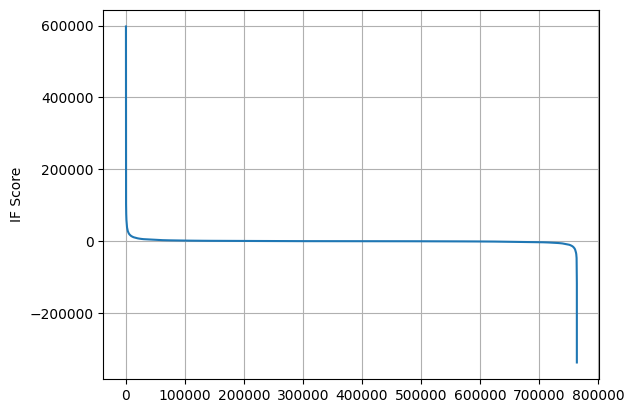

Query Sequence:
Text: the toys on the table are

Top Positive Influential Sequences:
Rank = 0; Score = 597738.9375
did you put the toys on the table ?
Rank = 1; Score = 407789.34375
the wheels on the truck go round and round !
Rank = 2; Score = 289161.90625
that's right the guy on the cover's playing tennis .
Rank = 3; Score = 283633.40625
no let's put the things on the table for the party .
Rank = 4; Score = 282312.0
see how the leaves on the tree have changed .
Rank = 5; Score = 274980.21875
book those are the books on the table very good sweetie .
Rank = 6; Score = 264023.4375
the little girl on the telephone is named nina ?
Rank = 7; Score = 253198.734375
no we can't put the chair on the stairs the chair will fall down the stairs .
Rank = 8; Score = 252803.484375
the old lady on the bus steps in and out in and out in and out .
Rank = 9; Score = 248778.53125
the toys that becky drew are called duckie designs because her parents used to call her ducky .
Top Negative Influential Seque

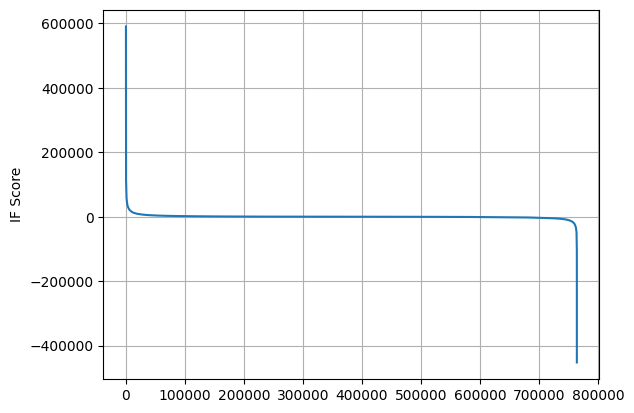

Query Sequence:
Text: the toys on the table is

Top Positive Influential Sequences:
Rank = 0; Score = 590455.9375
did you put the toys on the table ?
Rank = 1; Score = 476112.96875
the wheels on the truck go round and round !
Rank = 2; Score = 436297.84375
the little girl on the telephone is named nina ?
Rank = 3; Score = 423855.78125
no we can't put the chair on the stairs the chair will fall down the stairs .
Rank = 4; Score = 403487.34375
that's right the guy on the cover's playing tennis .
Rank = 5; Score = 367206.90625
the toys that becky drew are called duckie designs because her parents used to call her ducky .
Rank = 6; Score = 366043.84375
the old lady on the bus steps in and out in and out in and out .
Rank = 7; Score = 364720.15625
see how the leaves on the tree have changed .
Rank = 8; Score = 360073.21875
the people on the boat threw peanuts into the water and so the mallards followed them all around the pond and got another breakfast ?
Rank = 9; Score = 278840.34375
want 

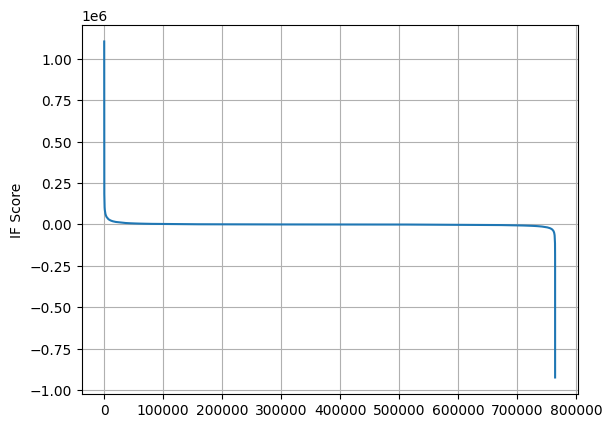

Query Sequence:
Text: i think the toy on the table is

Top Positive Influential Sequences:
Rank = 0; Score = 1104864.375
oh i think everybody in the village is ready to go to sleep now don't you .
Rank = 1; Score = 847010.75
want see how the leaf on this tree feels .
Rank = 2; Score = 778754.6875
that's right the guy on the cover's playing tennis .
Rank = 3; Score = 765670.75
no we can't put the chair on the stairs the chair will fall down the stairs .
Rank = 4; Score = 763674.4375
maybe he'd like to go down the slide let's see if the little boy can go down the slide bzz oops .
Rank = 5; Score = 757271.1875
you know sometimes i think mr lyons on the bozo show is captain bob .
Rank = 6; Score = 738785.3125
see how the leaves on the tree have changed .
Rank = 7; Score = 633098.75
uh i think a trip to the bathroom sink would be good ?
Rank = 8; Score = 622623.125
oh now i'm going put the cookie on the milk milk on the cookie .
Rank = 9; Score = 612575.5
the little girl on the telephone is

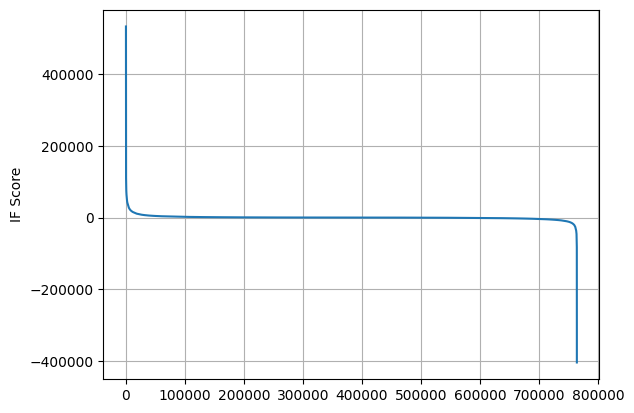

Query Sequence:
Text: i think the toy on the table are

Top Positive Influential Sequences:
Rank = 0; Score = 532104.25
oh i think everybody in the village is ready to go to sleep now don't you .
Rank = 1; Score = 372879.875
want see how the leaf on this tree feels .
Rank = 2; Score = 359991.53125
that's right the guy on the cover's playing tennis .
Rank = 3; Score = 354368.21875
see how the leaves on the tree have changed .
Rank = 4; Score = 332467.9375
you think the gas from our car made my feet dirty ?
Rank = 5; Score = 323662.96875
you know sometimes i think mr lyons on the bozo show is captain bob .
Rank = 6; Score = 323104.5625
maybe the wipers on the car are gonna brush off the snow for him .
Rank = 7; Score = 312336.8125
maybe he'd like to go down the slide let's see if the little boy can go down the slide bzz oops .
Rank = 8; Score = 292472.90625
uh i think a trip to the bathroom sink would be good ?
Rank = 9; Score = 288921.03125
i think the dog the duck and the frog are brok

In [4]:
# Qualitative Showcase
qualitative(attn_scores, eval_dataset, M)

Processing Pair: Eval 0 and Eval 1
Metrics:
Spearman: 0.0085
Kendall: 0.0057


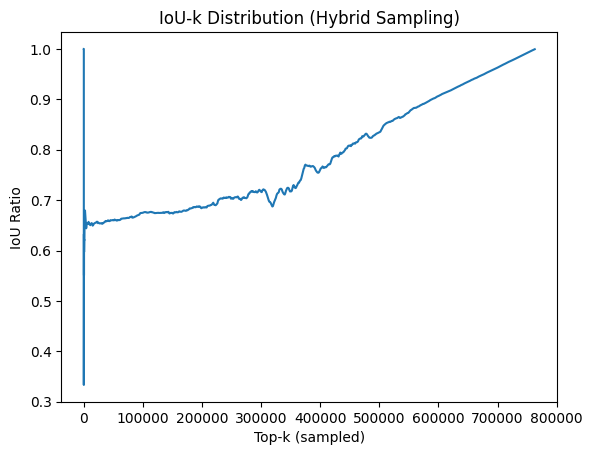

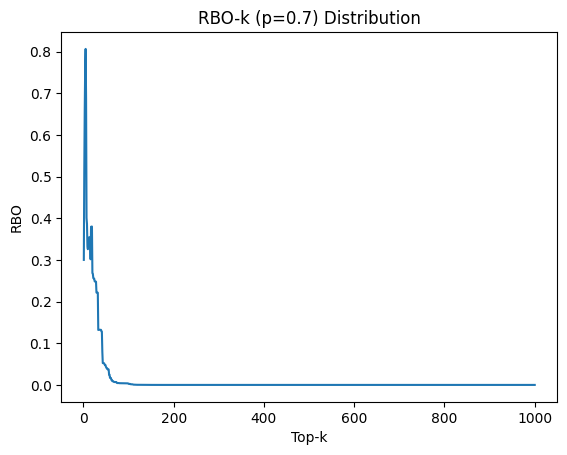

Processing Pair: Eval 2 and Eval 3
Metrics:
Spearman: 0.0083
Kendall: 0.0055


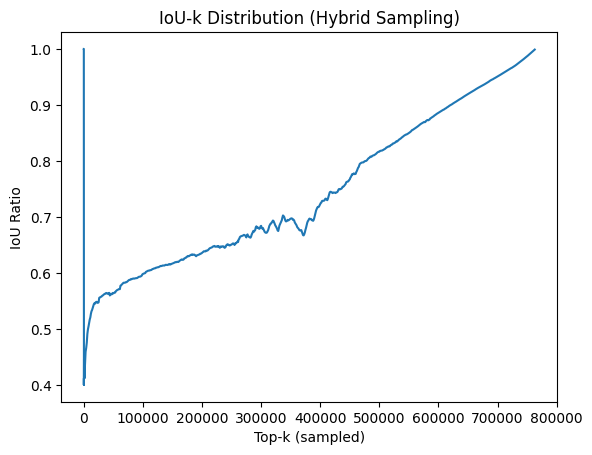

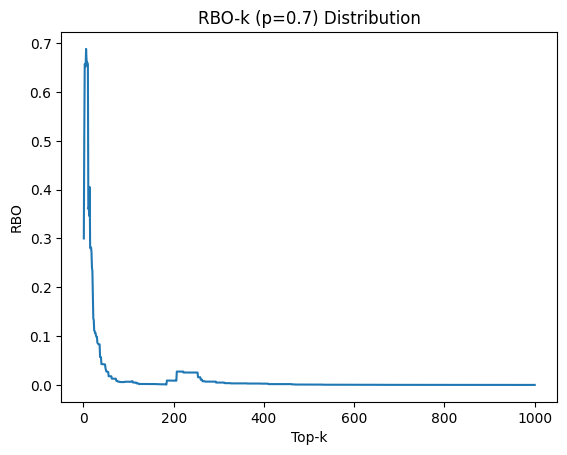

In [5]:
quantitative(attn_scores)